# Información de hardware
https://colab.research.google.com/notebooks/pro.ipynb?authuser=2#scrollTo=23TOba33L4qf

## **GRUPO 6 - MODELO DEEP LEARNING PARA DETECCIÓN DE GLAUCOMA**

El glaucoma es una enfermedad neurodegenerativa irreversible que puede causar pérdida de visión parcial o completa. La detección temprana y precisa puede prevenir la pérdida de visión. Por este motivo, surge la necesidad de desarrollar alternativas para su diagnóstico con alta precisión.

<img src=https://cdn.www.gob.pe/uploads/document/file/305118/Foto_OFTALMOLOG%C3%8DA_.jpg>

Con el presente modelo proponemos un método para el diagnóstico temprano del glaucoma. Para la ejecución del modelo, hacemos uso de imágenes de fondos de ojo de dataset públicos de RIM-ONE con un total de 455 imágenes (194 normal y 261 glaucoma).

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Verifica si hay una GPU disponible en el entorno de ejecución y
# proporciona instrucciones para habilitar la aceleración GPU si no se detecta.

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)


Sun May 26 18:06:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory

# Mide la cantidad de RAM disponible en el entorno de ejecución y
# proporciona instrucciones para cambiar a un entorno de alta RAM si es necesario.

ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')


Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


### Conectado a Google Drive

In [ ]:
# Se monta Google Drive en el entorno de Google Colab,

from google.colab import drive
drive.mount('/content/drive')

### Librerias

In [ ]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import math

import keras.callbacks  # Módulo de callbacks de Keras para manejar eventos durante el entrenamiento del modelo.
from keras.layers import *  # Capas disponibles en Keras para construir modelos de redes neuronales.
from keras.applications import *  # Aplicaciones preentrenadas disponibles en Keras.
from keras.models import Model  # Model de Keras para construir y entrenar modelos.
from keras.preprocessing.image import ImageDataGenerator  # ImageDataGenerator para la generación de datos de imágenes en tiempo real.
from keras.callbacks import ModelCheckpoint, EarlyStopping  # Callbacks ModelCheckpoint y EarlyStopping para guardar el mejor modelo y detener el entrenamiento temprano.
from keras import optimizers  # Optimizadores disponibles en Keras para ajustar el aprendizaje del modelo.

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix


### Variables globales - (Guardar resultados)

In [ ]:
gb_dataset_type  = 'Fundus'
gb_dataset_name  = 'RIM'

gb_datasets_dir  = os.path.join('/content/drive/MyDrive/Colab Notebooks/DataSets', gb_dataset_type, gb_dataset_name)
gb_result_dir    = os.path.join('/content/drive/MyDrive/Colab Notebooks/ResultadosEntrenamiento', gb_dataset_type, gb_dataset_name)

gb_nb_clases  = 2

### Graficar precisión y perdidas

In [ ]:
def plot_loss_accurancy(history, write_path):
  #Valores a graficar
  acc      = history.history['accuracy']
  val_acc  = history.history['val_accuracy']
  loss     = history.history['loss']
  val_loss = history.history['val_loss']

  #Definir gráficos
  plt.figure(1)
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.legend(['Train', 'Validation'], loc='upper left')
  fig_accu =  plt.figure(1)

  plt.figure(2)
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('Model Losses')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend(['Train', 'Validation'], loc='upper left')
  fig_loss =  plt.figure(2)
  plt.show()

  #Guardar gráficos
  fig_accu.savefig(os.path.join(gb_result_dir, write_path + 'accu.png'))
  fig_loss.savefig(os.path.join(gb_result_dir, write_path + 'loss.png'))

  #Guardar datos de entrenamiento
  df_a = pd.DataFrame(acc, columns = ['accuracy'])
  df_b = pd.DataFrame(val_acc, columns = ['val_accuracy'])
  df_c = pd.DataFrame(loss, columns = ['loss'])
  df_d = pd.DataFrame(val_loss, columns = ['val_loss'])

  frames = [df_a,df_b,df_c,df_d]
  df = pd.concat(frames, axis=1)

  df.to_csv(os.path.join(gb_result_dir, write_path + 'History.csv'), index=False)

  print('Datos entrenamiento y Gráficos guardados!!!\n')

### Guardar resultados modelo y pesos

In [ ]:
def save_model_weigths(model,write_path):
  #Save model
  # model_json = model.to_json()
  # with open(os.path.join(gb_result_dir, write_path + 'model.json'), "w") as json_file:
  #     json_file.write(model_json)

  #Save weigths
  # model.save(os.path.join(gb_result_dir, write_path + 'weigths.h5'))

  print('\nModelo y pesos guardados!!!\n')

### Guardar resultados de valid-test

In [ ]:
# Guarda los resultados de la clasificación en un archivo CSV,
# combinando varias estadísticas en un solo DataFrame.

def save_results(stats, write_path):
  df_a = pd.DataFrame(stats[0][0], columns=['Filenames'])
  df_b = pd.DataFrame(stats[0][1], columns=['classes'])
  df_c = pd.DataFrame(stats[0][2], columns=['prob_clase_1','prob_clase_2'])
  df_d = pd.DataFrame(stats[0][3], columns=['pred'])

  frames = [df_a,df_b,df_c,df_d]

  df = pd.concat(frames, axis=1)
  df.to_csv(write_path, index=False)

  flg_message = False if 'ValidPredicts.csv' in write_path else True

  if flg_message:
    print('Test.csv guardado!!!')

### Dimensiones

In [ ]:
# Devuelve las dimensiones de la imagen (ancho y alto)
# basadas en el modelo de CNN seleccionado.

def getImageDims(model):
    if model == 'VGG16' or model == 'VGG19' or model == 'InceptionResNetV2':
        width, height = 224, 224

    elif model == 'ResNet50' or model == 'ResNet101' or model == 'ResNet50V2':
        width, height = 224, 224

    elif model == 'DenseNet121' or model == 'DenseNet169':
        width, height = 224, 224

    elif model == 'InceptionV3' or model == 'Xception':
        width, height = 299, 299

    elif model == 'NASNetLarge':
        width, height = 331, 331

    elif model == 'MobileNet' or model == 'MobileNetV2' or model == 'NASNetMobile':
        width, height = 224, 224

    return width, height

### Fine tuning class


In [ ]:
# Se establece una semilla aleatoria para NumPy y TensorFlow,
# para garantizar la reproducibilidad de los resultados en cada ejecución.

seed = 101
np.random.seed(seed=seed)
tf.random.set_seed(seed=seed)

In [ ]:
# Esta clase define un generador de clasificadores CNN que puede entrenar, evaluar y
# clasificar imágenes utilizando un modelo preentrenado. Permite configurar hiperparámetros
# como el número de épocas, el tamaño del lote, la tasa de aprendizaje y las capas superiores.
# También incluye métodos para el entrenamiento y evaluación del modelo con generadores de datos aumentados.


class CNN_classifier_generator(object):
    def __init__(self, classifier_name, numEpochs, batch_size, learning_rate, top_model, based_model_last_block_layer_number, train_dir,
                 valid_dir, test_dir, nomenclature):
        # Inicializa los parámetros y construye el modelo CNN preentrenado con capas superiores personalizables.

        # Hiperparámetros para el modelo
        self.modelNameResults = classifier_name  # Nombre del clasificador
        self.based_model_last_block_layer_number = based_model_last_block_layer_number  # Basado en el modelo seleccionado
        self.img_width, self.img_height = getImageDims(self.modelNameResults)  # Dimensiones de la imagen según la arquitectura
        self.batch_size = batch_size  # Tamaño del lote
        self.numEpochs = numEpochs  # Número de épocas
        self.nb_classes = gb_nb_clases  # Número de clases
        self.learn_rate = learning_rate  # Tasa de aprendizaje
        self.momentum = .9  # Momentum del optimizador SGD
        self.transformation_ratio = .2  # Ratio de transformación para la augmentación de datos

        print('------------ lr: ' + str(self.learn_rate) + ' - batch_size: ' + str(self.batch_size) + '------------')

        # Directorios de datos
        self.train_dir = train_dir
        self.valid_dir = valid_dir
        self.test_dir = test_dir
        self.top_model = top_model
        self.nomenclature = nomenclature

        # Creación del modelo

        # Modelo CNN preentrenado utilizando el conjunto de datos imagenet para los pesos preentrenados
        base_model = globals()[self.modelNameResults](input_shape=(self.img_width, self.img_height, 3)
                               , weights='imagenet', include_top=False)

        # Primer tipo de fine-tuning
        if self.top_model == 1:
            x = base_model.output
            x = GlobalAveragePooling2D()(x)
            predictions = Dense(self.nb_classes, activation='softmax')(x)

        # Segundo tipo de fine-tuning
        elif self.top_model == 2:
            # Modelo superior personalizado
            x = base_model.output
            x = Flatten(input_shape=base_model.output_shape[1:])(x)
            x = Dense(256, activation='relu')(x)
            x = Dropout(0.4)(x)
            x = Dense(128, activation='relu')(x)
            x = Dropout(0.4)(x)
            predictions = Dense(self.nb_classes, activation='softmax')(x)

        # Añadir el bloque superior al modelo base
        self.model = Model(base_model.input, predictions)

    def train(self, nb_train_samples, nb_validation_samples):
        # Generador de datos para el entrenamiento
        train_datagen = ImageDataGenerator(
            rescale=1. / 255,  # Escala los valores de los píxeles entre 0 y 1
            rotation_range=self.transformation_ratio,  # Rango de rotación para la augmentación
            zoom_range=self.transformation_ratio,  # Rango de zoom para la augmentación
            cval=self.transformation_ratio,  # Valor constante utilizado para rellenar píxeles fuera del límite
            horizontal_flip=True,  # Voltea las imágenes horizontalmente
            vertical_flip=True  # Voltea las imágenes verticalmente
        )

        validation_datagen = ImageDataGenerator(rescale=1. / 255)

        train_generator = train_datagen.flow_from_directory(
            self.train_dir,
            target_size=(self.img_width, self.img_height),
            batch_size=self.batch_size,
            class_mode='categorical'
        )
        print(train_generator.samples)

        validation_generator = validation_datagen.flow_from_directory(
            self.valid_dir,
            target_size=(self.img_width, self.img_height),
            batch_size=self.batch_size,
            class_mode='categorical'
        )
        print(validation_generator.samples)

        # Definir las capas a usar del modelo base
        for layer in self.model.layers[:self.based_model_last_block_layer_number]:
            layer.trainable = False  # Congelar las capas iniciales del modelo base
        for layer in self.model.layers[self.based_model_last_block_layer_number:]:
            layer.trainable = True  # Descongelar las capas superiores del modelo base

        # Compilar el modelo con un optimizador SGD/momentum y una tasa de aprendizaje muy baja.
        self.model.compile(optimizer=optimizers.SGD(learning_rate=self.learn_rate, momentum=self.momentum),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

        print("\nStarting to Fine Tune Model\n")

        # Ajustar el modelo
        history = self.model.fit(
            train_generator,
            steps_per_epoch=nb_train_samples // self.batch_size,
            epochs=self.numEpochs,
            validation_data=validation_generator,
            validation_steps=nb_validation_samples // self.batch_size,
            verbose=1
        )

        # Guardar el modelo
        save_model_weigths(self.model, self.nomenclature)

        # Graficar la historia de pérdida y precisión
        plot_loss_accurancy(history, self.nomenclature)

    def classify(self, test_dir):
        # Leer los datos de prueba
        test_datagen = ImageDataGenerator(rescale=1. / 255)

        test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=(self.img_width, self.img_height),
            batch_size=self.batch_size,
            shuffle=False
        )

        # Calcular las probabilidades de clase
        y_probabilities = self.model.predict(
            test_generator,
            steps=np.math.ceil(test_generator.samples / float(test_generator.batch_size))
        )

        # Matriz de confusión
        y_pred = np.argmax(y_probabilities, axis=1)
        print('Classification Report')
        target_names = ['not_sick', 'sick']
        print(classification_report(test_generator.classes, y_pred, target_names=target_names, digits=4))

        return test_generator.filenames, test_generator.classes, y_probabilities, y_pred


### Entrenar modelo

In [ ]:
# Esta función entrena, evalúa y guarda un modelo de clasificación CNN. Configura los directorios de datos,
# inicializa los hiperparámetros, crea una instancia del clasificador CNN, cuenta las muestras de entrenamiento y validación,
# entrena el modelo, lo evalúa y retorna los resultados de la clasificación.

def train_evaluate_save_model(f_arch, f_num_epochs, f_batch, f_lrate, f_top_model, f_nfold, f_nomenclature):
    data_dir = gb_datasets_dir + '/' + f_nfold + '/'  # Directorio principal de datos
    train_dir = data_dir + 'train/'  # Directorio de datos de entrenamiento
    valid_dir = data_dir + 'valid/'  # Directorio de datos de validación
    test_dir = data_dir + 'test/'  # Directorio de datos de prueba

    print('\n', data_dir)

    # Inicialización de los hiperparámetros
    arch = f_arch  # Arquitectura del modelo
    numEpochs = f_num_epochs  # Número de épocas
    batch_size = f_batch  # Tamaño del lote
    l_rate = f_lrate  # Tasa de aprendizaje
    top_model = f_top_model  # Tipo de fine-tunning
    layer2finetune = 0  # Número de capa para fine-tuning

    # Crear instancia del clasificador CNN
    classifier = CNN_classifier_generator(
        classifier_name=arch,
        numEpochs=numEpochs,
        batch_size=batch_size,
        learning_rate=l_rate,
        top_model=top_model,
        based_model_last_block_layer_number=layer2finetune,
        train_dir=train_dir,
        valid_dir=valid_dir,
        test_dir=test_dir,
        nomenclature=f_nomenclature
    )

    # Contar el número de muestras de entrenamiento y validación
    nb_train_samples = 0
    nb_validation_samples = 0

    for _, _, filesTrain in os.walk(train_dir):
        nb_train_samples = len(filesTrain)

    for _, _, filesDir in os.walk(valid_dir):
        nb_validation_samples = len(filesDir)

    # Entrenar el modelo
    classifier.train(nb_train_samples=nb_train_samples, nb_validation_samples=nb_validation_samples)

    # Evaluar el modelo
    print('----------Test----------')
    t_filenames, t_classes, t_probabilities, t_pred = classifier.classify(test_dir=test_dir)  # Clasificar imágenes

    return [t_filenames, t_classes, t_probabilities, t_pred]


### Validación cruzada 10k-Fods

In [ ]:
# Este script realiza la validación cruzada para entrenar y evaluar un modelo de clasificación CNN con diferentes
# hiperparámetros en varios pliegues (folds). Guarda los resultados de la clasificación en archivos CSV
# y los organiza por nomenclatura.

folds = ['Fold0']  # Lista de folds a usar para la validación cruzada
lrates = [1e-4,1e-5,1e-6,1e-7]  # Lista de tasas de aprendizaje a evaluar
epochs = [10, 20, 50, 100, 200, 250, 300]  # Lista de números de épocas a evaluar
batches = [8, 16, 32]  # Lista de tamaños de lote a evaluar

t_stats = list()  # Lista para almacenar estadísticas de las pruebas

def cross_validation(f_arch, f_top_model):
    count = 0
    for fold in folds:  # Itera sobre cada pliegue
        for lrate in lrates:  # Itera sobre cada tasa de aprendizaje
            for epoch in epochs:  # Itera sobre cada número de épocas
                for batch in batches:  # Itera sobre cada tamaño de lote

                    t_stats.clear()  # Limpia las estadísticas previas

                    print('\n\n---------------------Parametros | Hiperparametros--------------------')
                    print('Recorrido: ' + str(count) + '\t' + fold + '\tlr: ' + str(lrate) + '\tbatch: ' + str(batch) + '\tepoch: ' + str(epoch))
                    print('---------------------------------------------------------------------')

                    # Genera una nomenclatura única para los resultados
                    # basados en los hiperparámetros y el pliegue
                    nomenclature = str(gb_nb_clases) + '_' + f_arch +
                                  '_sm' + str(f_top_model) +
                                  '_bch' + str(batch) +
                                  '_lr' + str(lrate) +
                                  '_ep' + str(epoch) +
                                  '_ada_' + fold + '_'

                    print(nomenclature)

                    # Entrena, evalúa y guarda el modelo
                    result_test = train_evaluate_save_model(f_arch, epoch, batch, lrate, f_top_model, fold, nomenclature)

                    # Guarda los resultados de la prueba
                    t_stats.append(result_test)

                    # Guarda los resultados en un archivo CSV
                    save_results(t_stats, os.path.join(gb_result_dir, nomenclature + 'TestPredicts.csv'))

                    count += 1
                    print('--------------------Fin fold ' + str(fold) + '--------------------')


### Entrenamiento de modelos

* DenseNet121
* DenseNet169
* InceptionV3
* MobileNet
* MobileNetV2
* NASNetMobile
* ResNet101
* ResNet50
* ResNet50V2
* VGG16
* VGG19
* Xception




---------------------Parametros | Hiperparametros--------------------
Recorrido: 0	Fold0	lr: 1e-05	batch: 8	epoch: 200
---------------------------------------------------------------------
2_ResNet50_sm1_bch8_lr1e-05_ep200_ada_Fold0_

 /content/drive/MyDrive/Colab Notebooks/DataSets/Fundus/RIM/Fold0/
------------ lr: 1e-05 - batch_size: 8------------
Found 368 images belonging to 2 classes.
368
Found 46 images belonging to 2 classes.
46

Starting to Fine Tune Model

Epoch 1/200
27/27 [==============================] - 36s 242ms/step - loss: 0.8062 - accuracy: 0.5509 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 2/200
27/27 [==============================] - 4s 151ms/step - loss: 0.7247 - accuracy: 0.6065 - val_loss: 0.7299 - val_accuracy: 0.3750
Epoch 3/200
27/27 [==============================] - 4s 164ms/step - loss: 0.7265 - accuracy: 0.5741 - val_loss: 0.9618 - val_accuracy: 0.6250
Epoch 4/200
27/27 [==============================] - 5s 196ms/step - loss: 0.7331 - accuracy: 0.5

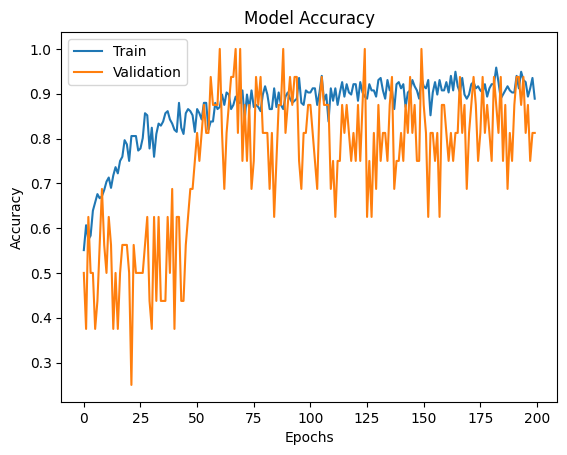

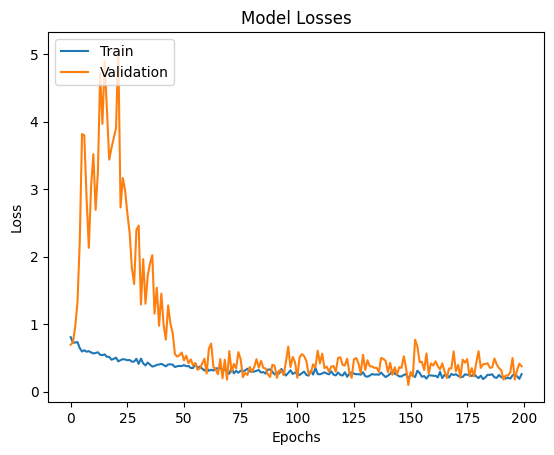

Datos entrenamiento y Gráficos guardados!!!

----------Test----------
Found 41 images belonging to 2 classes.
6/6 [==============================] - 10s 2s/step
Classification Report
              precision    recall  f1-score   support

    not_sick     0.8400    0.9545    0.8936        22
        sick     0.9375    0.7895    0.8571        19

    accuracy                         0.8780        41
   macro avg     0.8887    0.8720    0.8754        41
weighted avg     0.8852    0.8780    0.8767        41

Test.csv guardado!!!
--------------------Fin fold Fold0--------------------


In [ ]:
cross_validation('ResNet50', 1)



---------------------Parametros | Hiperparametros--------------------
Recorrido: 0	Fold0	lr: 1e-05	batch: 8	epoch: 200
---------------------------------------------------------------------
2_ResNet50V2_sm2_bch8_lr1e-05_ep200_ada_Fold0_

 /content/drive/MyDrive/Colab Notebooks/DataSets/Fundus/RIM/Fold0/
------------ lr: 1e-05 - batch_size: 8------------
94668760/94668760 [==============================] - 1s 0us/step
Found 368 images belonging to 2 classes.
368
Found 46 images belonging to 2 classes.
46

Starting to Fine Tune Model

Epoch 1/200
27/27 [==============================] - 24s 238ms/step - loss: 1.7120 - accuracy: 0.4537 - val_loss: 1.1199 - val_accuracy: 0.5000
Epoch 2/200
27/27 [==============================] - 4s 147ms/step - loss: 1.0110 - accuracy: 0.5139 - val_loss: 0.6792 - val_accuracy: 0.6875
Epoch 3/200
27/27 [==============================] - 4s 149ms/step - loss: 0.8890 - accuracy: 0.5602 - val_loss: 0.5940 - val_accuracy: 0.6875
Epoch 4/200
27/27 [===========

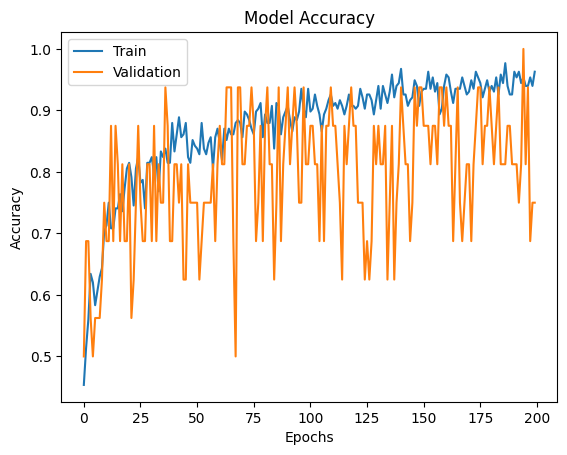

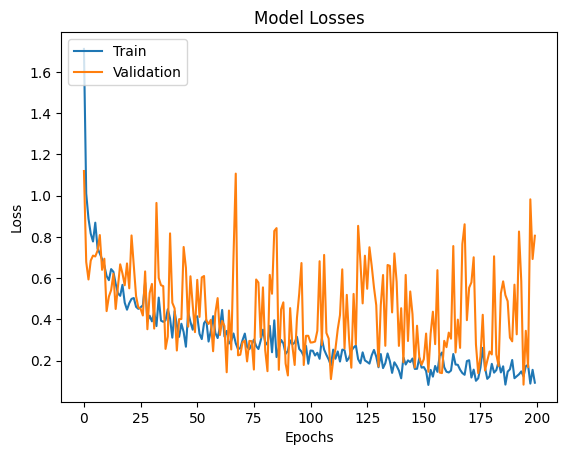

Datos entrenamiento y Gráficos guardados!!!

----------Test----------
Found 41 images belonging to 2 classes.
6/6 [==============================] - 2s 193ms/step
Classification Report
              precision    recall  f1-score   support

    not_sick     0.9091    0.9091    0.9091        22
        sick     0.8947    0.8947    0.8947        19

    accuracy                         0.9024        41
   macro avg     0.9019    0.9019    0.9019        41
weighted avg     0.9024    0.9024    0.9024        41

Test.csv guardado!!!
--------------------Fin fold Fold0--------------------


In [ ]:
cross_validation('ResNet50V2', 2)



---------------------Parametros | Hiperparametros--------------------
Recorrido: 0	Fold0	lr: 1e-05	batch: 8	epoch: 200
---------------------------------------------------------------------
2_DenseNet169_sm2_bch8_lr1e-05_ep200_ada_Fold0_

 /content/drive/MyDrive/Colab Notebooks/DataSets/Fundus/RIM/Fold0/
------------ lr: 1e-05 - batch_size: 8------------
51877672/51877672 [==============================] - 0s 0us/step
Found 368 images belonging to 2 classes.
368
Found 46 images belonging to 2 classes.
46

Starting to Fine Tune Model

Epoch 1/200
27/27 [==============================] - 67s 328ms/step - loss: 1.0759 - accuracy: 0.4954 - val_loss: 1.0770 - val_accuracy: 0.4375
Epoch 2/200
27/27 [==============================] - 5s 167ms/step - loss: 0.9209 - accuracy: 0.5741 - val_loss: 0.8454 - val_accuracy: 0.5625
Epoch 3/200
27/27 [==============================] - 6s 233ms/step - loss: 0.8548 - accuracy: 0.5880 - val_loss: 0.7750 - val_accuracy: 0.5000
Epoch 4/200
27/27 [==========

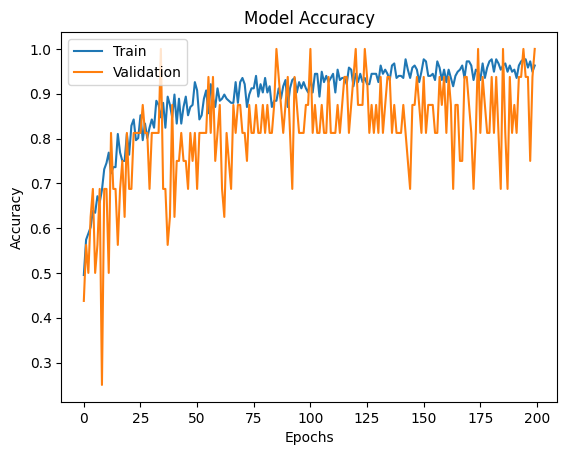

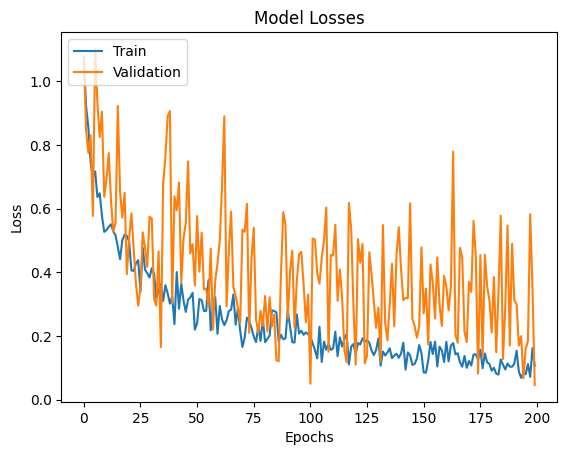

Datos entrenamiento y Gráficos guardados!!!

----------Test----------
Found 41 images belonging to 2 classes.
6/6 [==============================] - 6s 581ms/step
Classification Report
              precision    recall  f1-score   support

    not_sick     0.8000    0.9091    0.8511        22
        sick     0.8750    0.7368    0.8000        19

    accuracy                         0.8293        41
   macro avg     0.8375    0.8230    0.8255        41
weighted avg     0.8348    0.8293    0.8274        41

Test.csv guardado!!!
--------------------Fin fold Fold0--------------------


In [ ]:
cross_validation('DenseNet169', 2)



---------------------Parametros | Hiperparametros--------------------
Recorrido: 0	Fold0	lr: 1e-05	batch: 8	epoch: 200
---------------------------------------------------------------------
2_VGG16_sm1_bch8_lr1e-05_ep200_ada_Fold0_

 /content/drive/MyDrive/Colab Notebooks/DataSets/Fundus/RIM/Fold0/
------------ lr: 1e-05 - batch_size: 8------------
58889256/58889256 [==============================] - 0s 0us/step
Found 368 images belonging to 2 classes.
368
Found 46 images belonging to 2 classes.
46

Starting to Fine Tune Model

Epoch 1/200
27/27 [==============================] - 14s 216ms/step - loss: 0.7179 - accuracy: 0.3750 - val_loss: 0.6931 - val_accuracy: 0.3750
Epoch 2/200
27/27 [==============================] - 6s 213ms/step - loss: 0.6720 - accuracy: 0.6481 - val_loss: 0.6823 - val_accuracy: 0.5625
Epoch 3/200
27/27 [==============================] - 4s 160ms/step - loss: 0.6691 - accuracy: 0.5741 - val_loss: 0.7234 - val_accuracy: 0.4375
Epoch 4/200
27/27 [================

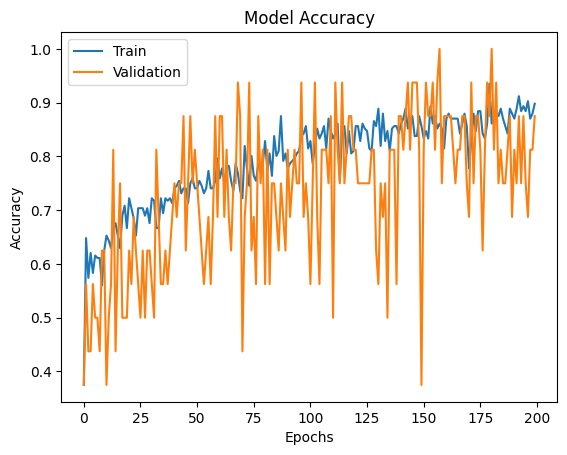

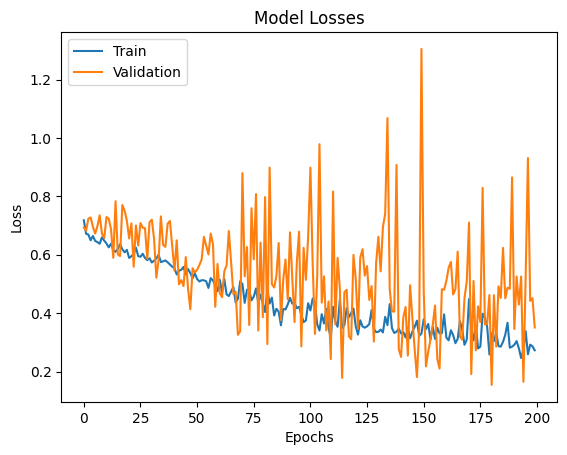

Datos entrenamiento y Gráficos guardados!!!

----------Test----------
Found 41 images belonging to 2 classes.
6/6 [==============================] - 1s 235ms/step
Classification Report
              precision    recall  f1-score   support

    not_sick     0.7407    0.9091    0.8163        22
        sick     0.8571    0.6316    0.7273        19

    accuracy                         0.7805        41
   macro avg     0.7989    0.7703    0.7718        41
weighted avg     0.7947    0.7805    0.7751        41

Test.csv guardado!!!
--------------------Fin fold Fold0--------------------


In [ ]:
cross_validation('VGG16', 1)



---------------------Parametros | Hiperparametros--------------------
Recorrido: 0	Fold0	lr: 1e-05	batch: 8	epoch: 200
---------------------------------------------------------------------
2_DenseNet169_sm1_bch8_lr1e-05_ep200_ada_Fold0_

 /content/drive/MyDrive/Colab Notebooks/DataSets/Fundus/RIM/Fold0/
------------ lr: 1e-05 - batch_size: 8------------
Found 368 images belonging to 2 classes.
368
Found 46 images belonging to 2 classes.
46

Starting to Fine Tune Model

Epoch 1/200
27/27 [==============================] - 55s 340ms/step - loss: 0.7241 - accuracy: 0.5417 - val_loss: 0.7578 - val_accuracy: 0.5000
Epoch 2/200
27/27 [==============================] - 5s 173ms/step - loss: 0.6433 - accuracy: 0.6019 - val_loss: 0.7657 - val_accuracy: 0.5000
Epoch 3/200
27/27 [==============================] - 6s 227ms/step - loss: 0.6187 - accuracy: 0.6574 - val_loss: 0.6805 - val_accuracy: 0.6250
Epoch 4/200
27/27 [==============================] - 5s 187ms/step - loss: 0.6319 - accuracy: 

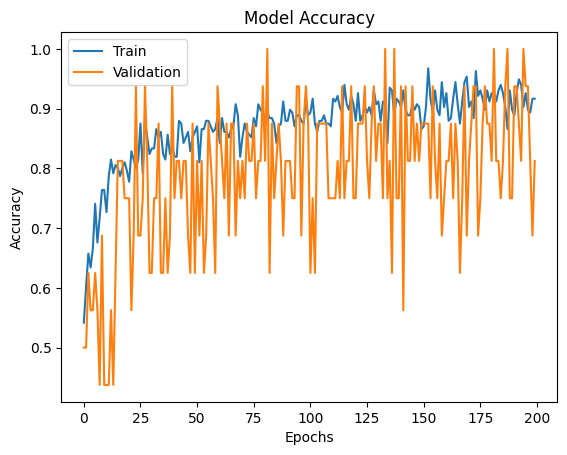

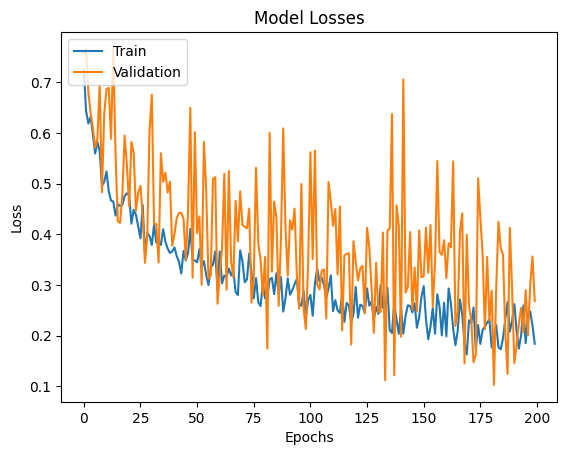

Datos entrenamiento y Gráficos guardados!!!

----------Test----------
Found 41 images belonging to 2 classes.
6/6 [==============================] - 4s 61ms/step
Classification Report
              precision    recall  f1-score   support

    not_sick     0.9091    0.9091    0.9091        22
        sick     0.8947    0.8947    0.8947        19

    accuracy                         0.9024        41
   macro avg     0.9019    0.9019    0.9019        41
weighted avg     0.9024    0.9024    0.9024        41

Test.csv guardado!!!
--------------------Fin fold Fold0--------------------


In [ ]:
cross_validation('DenseNet169', 1)



---------------------Parametros | Hiperparametros--------------------
Recorrido: 0	Fold0	lr: 1e-05	batch: 8	epoch: 200
---------------------------------------------------------------------
2_Xception_sm1_bch8_lr1e-05_ep200_ada_Fold0_

 /content/drive/MyDrive/Colab Notebooks/DataSets/Fundus/RIM/Fold0/
------------ lr: 1e-05 - batch_size: 8------------
83683744/83683744 [==============================] - 1s 0us/step
Found 368 images belonging to 2 classes.
368
Found 46 images belonging to 2 classes.
46

Starting to Fine Tune Model

Epoch 1/200
27/27 [==============================] - 27s 342ms/step - loss: 0.7030 - accuracy: 0.5185 - val_loss: 0.7191 - val_accuracy: 0.4375
Epoch 2/200
27/27 [==============================] - 7s 255ms/step - loss: 0.7001 - accuracy: 0.4907 - val_loss: 0.7221 - val_accuracy: 0.5625
Epoch 3/200
27/27 [==============================] - 8s 271ms/step - loss: 0.6756 - accuracy: 0.5741 - val_loss: 0.6857 - val_accuracy: 0.5625
Epoch 4/200
27/27 [=============

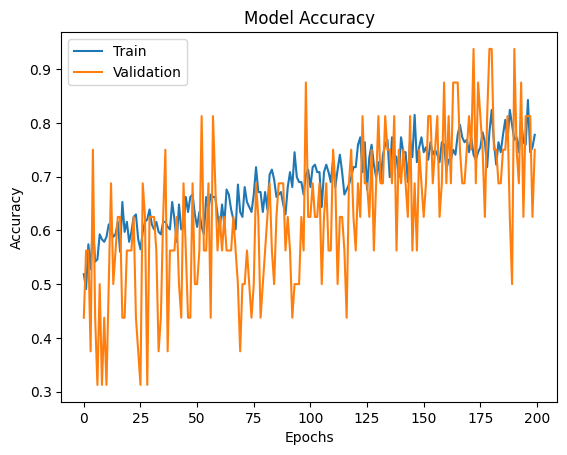

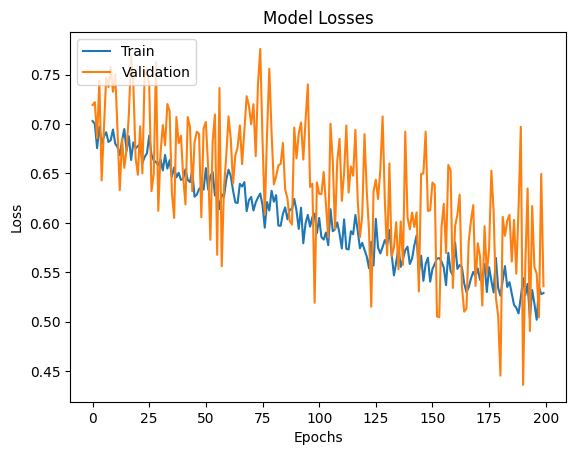

Datos entrenamiento y Gráficos guardados!!!

----------Test----------
Found 41 images belonging to 2 classes.
6/6 [==============================] - 2s 202ms/step
Classification Report
              precision    recall  f1-score   support

    not_sick     0.8667    0.5909    0.7027        22
        sick     0.6538    0.8947    0.7556        19

    accuracy                         0.7317        41
   macro avg     0.7603    0.7428    0.7291        41
weighted avg     0.7680    0.7317    0.7272        41

Test.csv guardado!!!
--------------------Fin fold Fold0--------------------


In [ ]:
cross_validation('Xception', 1)

In [ ]:
print('Fin!!!')

Fin!!!
